In [ ]:
import pandas as pd
import json
import shapely
from shapely.geometry import Point
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Proj, transform
from ipyleaflet import Map, Heatmap
import re
import seaborn as sns 
import sklearn.svm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
%matplotlib inline

In [43]:
df = pd.read_pickle('../data/funda_utrecht.en.pkl')
gdf = gpd.GeoDataFrame(df)

In [3]:
catcols = ['energy_label','parking','heating','hot_water']# 'address','street','area_code']
realcols = ['layer','living_area','no_bedrooms','no_layers','no_rooms','energy_rating','station_distance','construction_year']

In [4]:
cat_si_step = ('si', SimpleImputer(strategy='constant',
                   fill_value='MISSING'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                    handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_transformers = [('cat', cat_pipe, catcols)]
ct = ColumnTransformer(transformers=cat_transformers)
cat_tr = ct.fit_transform(df[catcols])
cat_tr_names = ct.transformers_[0][1].steps[1][1].get_feature_names()

In [5]:
mdldata = pd.DataFrame(cat_tr,columns=cat_tr_names)

In [6]:
for realcol in realcols:
    m = df[realcol].astype(np.float).dropna().mean()
    mdldata[realcol] = df[realcol].astype(np.float).fillna(m)

In [7]:
svm = sklearn.svm.SVR(kernel='linear',C=100.0,epsilon=50.0)
svm.fit(mdldata,df['price'].fillna(df['price'].mean()))

SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=50.0,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [8]:
price_pred = pd.DataFrame(svm.predict(mdldata),columns=['pred'])
price_pred['gnd'] = df['price']
price_pred['diff'] = df['price'].fillna(price_pred['gnd'].mean()) - svm.predict(mdldata)

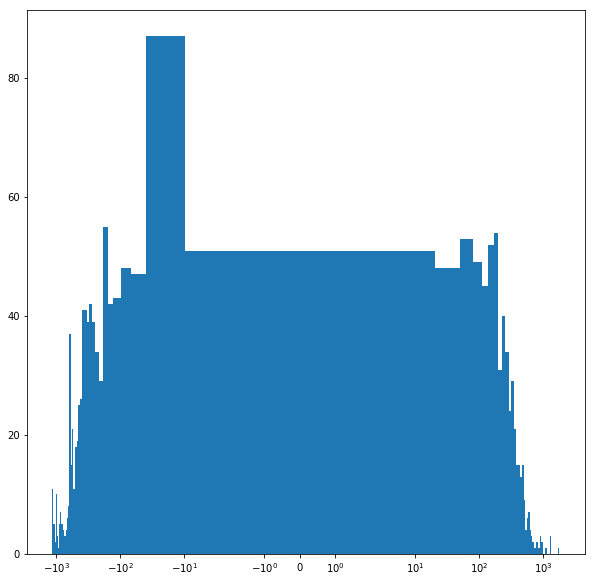

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(price_pred['diff'],bins=100,);
ax.set_xscale('symlog')

In [10]:
svmw = pd.Series(svm.coef_.T[:,0], index=mdldata.columns)
svmw.sort_values()

x3_Gas-fired                                                                   -464.824538
no_bedrooms                                                                    -312.095067
x1_MISSING                                                                     -226.150330
x0_B                                                                           -220.341120
x3_Gas-fired combination boiler, in ownership                                  -208.456056
x2_Gas water heater (rental)                                                   -200.000000
x1_Underground parking                                                         -200.000000
x3_Combiketel HR 107 (gas-fired from 2009, to rent)                            -200.000000
x1_Detached wooden storage Electricity                                         -200.000000
x2_Complete floor heating                                                      -200.000000
x3_Electrical boiler                                                           -200.000000

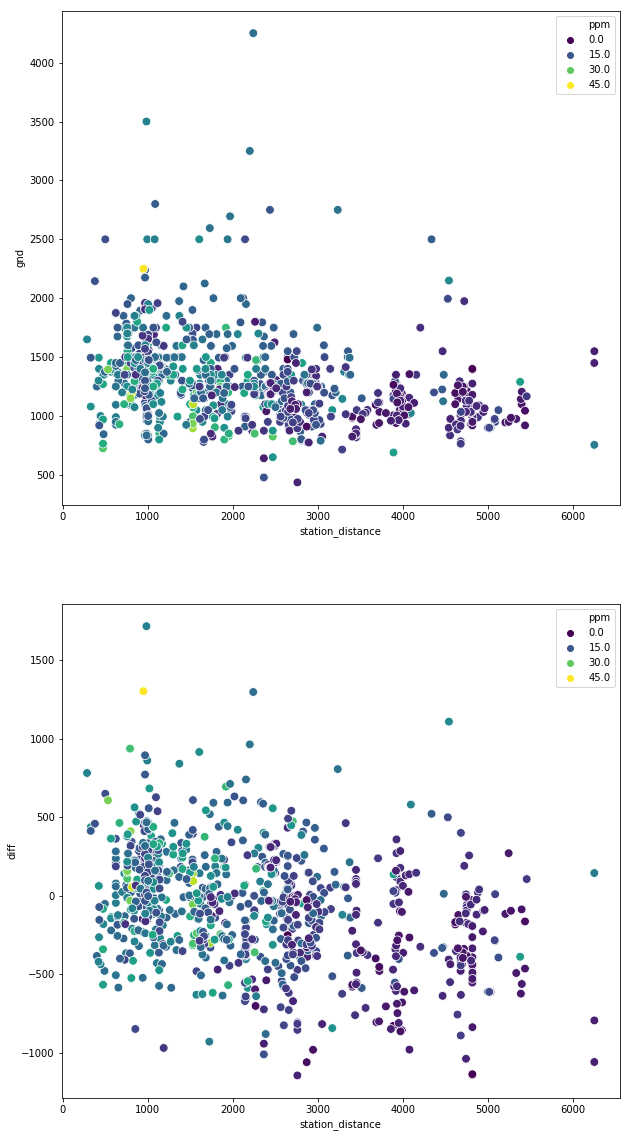

In [41]:
fig, axes = plt.subplots(2,figsize=(10,20))
sns.scatterplot(df['station_distance'],price_pred['gnd'],hue=df['ppm'], ax=axes[0],palette='viridis',s=76)
sns.scatterplot(df['station_distance'],price_pred['diff'],hue=df['ppm'], ax=axes[1],palette='viridis',s=76)

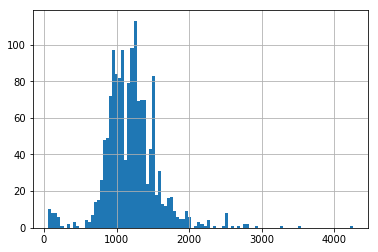

In [16]:
df.price.hist(bins=100)

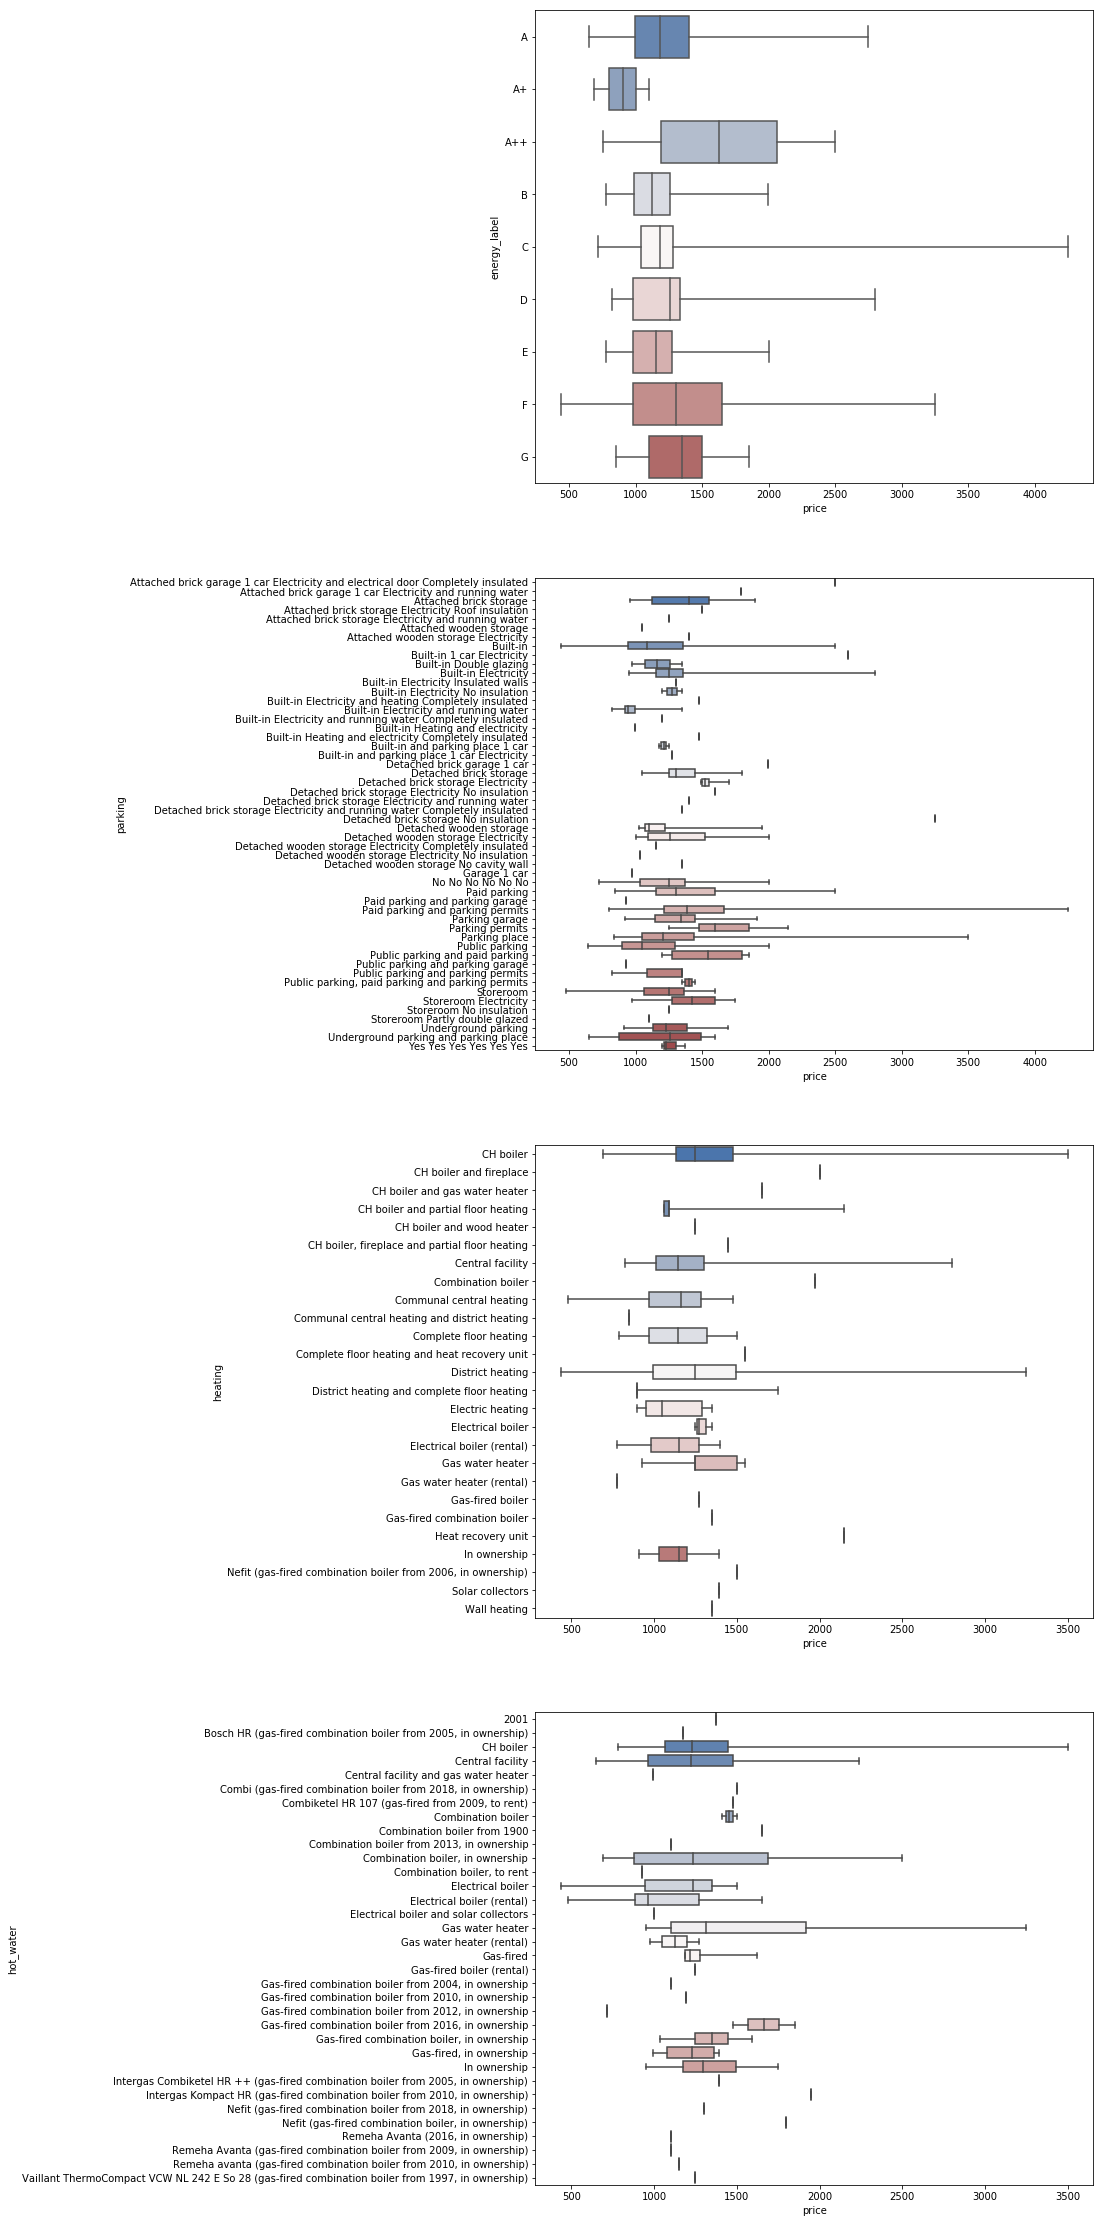

In [24]:
fig, axes = plt.subplots(len(catcols),figsize=(10,40))
for index in range(len(catcols)):
    sns.boxplot(x="price",y=catcols[index], data=df,
                whis="range", palette="vlag", ax=axes[index])

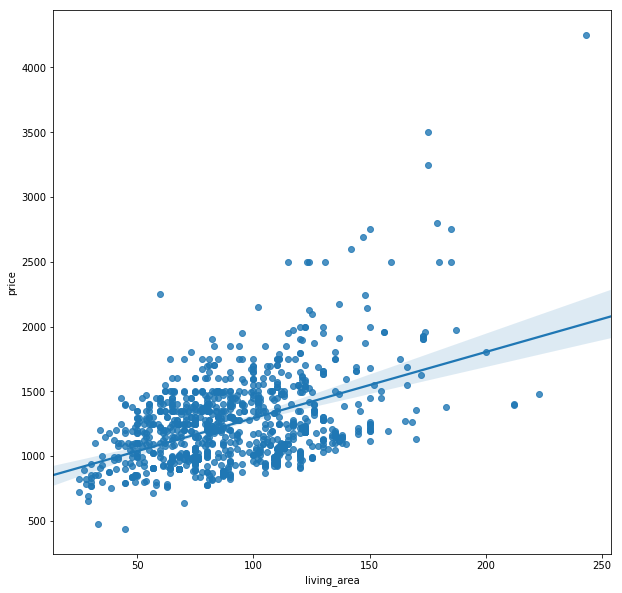

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(df['living_area'],df['price'],ax=ax)#,palette='viridis',s=76)

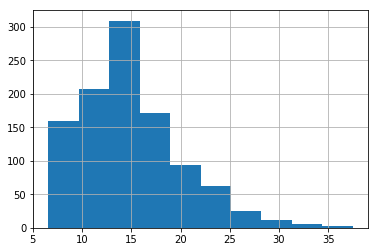

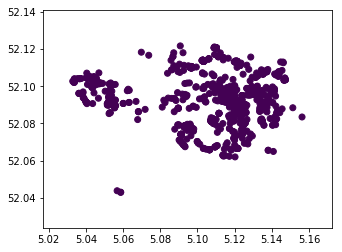

In [27]:
df['ppm'].hist()
gdf.plot(column='ppm')

In [28]:
points = filter(lambda x: isinstance(x,Point) and hasattr(x,'x'), gdf[price_pred['diff']<0]['geometry'])
cent = shapely.geometry.MultiPoint(points).centroid

In [29]:
m = Map(center=(cent.y,cent.x), zoom=14)
heatmap = Heatmap(
    locations= map(lambda x: (x.y,x.x),points),
    radius=20
)
m.add_layer(heatmap);
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[52.09410149014785, 5.101425142857145], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=[u'attribution', u'tile_size', u'min_zoom', u'max_zoom', u'detect_retina']), Heatmap(gradient={0.7: 'lime', 0.6: 'cyan', 0.4: 'blue', 0.8: 'yellow', 1.0: 'red'}, locations=[(52.1161, 5.116806), (52.09262, 5.113834), (52.10458, 5.040574), (52.10099, 5.053197), (52.09246, 5.121156), (52.09869, 5.119648), (52.06287, 5.11375), (52.10483, 5.040854), (52.10452, 5.040579), (52.08547, 5.111642), (52.08547, 5.111642), (52.1161, 5.112757), (52.11585, 5.111233), (52.09349, 5.09791), (52.10693, 5.102758), (52.11467, 5.106218), (52.09519, 5.127587), (52.08597, 5.14405), (52.1047, 5.044993), (52.08568, 5.124907), (52.08815, 5.095613), (52.10799, 5.089851), (52.1086, 5.10391), (52.10479, 5.131361), (52.0831, 5.107401), (52.09623, 5.131769), (52.09491, 5.13305), (52.09145, 5.115523), (52.0988, 5.114052), (52.10344, 5.045663), (52.0781, 5.086313), (52.08619, 5.121255), (52.10601, 5.132142), (52.09866, 5.141517), (52.09871, 5.141524), (52.09771, 5.141418), (52.0781, 5.086313), (52.0781, 5.086313), (52.0781, 5.086313), (52.08794, 5.121257), (52.08681, 5.121653), (52.0862, 5.12044), (52.08736, 5.119822), (52.0779, 5.090464), (52.07858, 5.09122), (52.07858, 5.09122), (52.07858, 5.09122), (52.07924, 5.089404), (52.07862, 5.091241), (52.07902, 5.090183), (52.08528, 5.142811), (52.09447, 5.136796), (52.09846, 5.114304), (52.09672, 5.116295), (52.09102, 5.116848), (52.09043, 5.118258), (52.09495, 5.127495), (52.09043, 5.118258), (52.09212, 5.115781), (52.10384, 5.119807), (52.10369, 5.119176), (52.10365, 5.119125), (52.09616, 5.121689), (52.09505, 5.117739), (52.0914, 5.115864), (52.0915, 5.118947), (52.09014, 5.118302), (52.0915, 5.118947), (52.09719, 5.115506), (52.09847, 5.115786), (52.09877, 5.115553), (52.10236, 5.111963), (52.09881, 5.113986), (52.09846, 5.114304), (52.079, 5.09434), (52.07959, 5.09461), (52.07616, 5.099366), (52.07714, 5.0951), (52.07959, 5.09461), (52.07831, 5.09421), (52.09246, 5.121156), (52.10413, 5.035519), (52.11346, 5.12141), (52.08853, 5.05547), (52.0662, 5.11786), (52.09956, 5.137522), (52.09445, 5.053038), (52.09259, 5.055893), (52.0974, 5.053993), (52.09504, 5.053712), (52.07482, 5.124723), (52.09079, 5.060147), (52.11346, 5.12141), (52.11261, 5.120817), (52.11346, 5.12141), (52.0914, 5.13859), (52.0929, 5.139651), (52.09165, 5.136491), (52.08731, 5.135262), (52.08975, 5.135455), (52.11346, 5.12141), (52.11368, 5.120661), (52.11121, 5.122993), (52.1125, 5.12348), (52.11121, 5.122993), (52.11261, 5.120817), (52.11121, 5.122993), (52.0896, 5.05608), (52.09079, 5.060147), (52.08956, 5.055958), (52.07593, 5.126664), (52.07655, 5.123613), (52.07428, 5.124182), (52.07331, 5.120693), (52.09578, 5.140201), (52.09851, 5.138345), (52.0958, 5.140203), (52.09578, 5.140228), (52.09652, 5.139851), (52.09582, 5.140211), (52.08039, 5.113782), (52.09491, 5.13305), (52.09821, 5.121196), (52.0953, 5.13379), (52.11318, 5.11986), (52.10662, 5.13167), (52.08912, 5.137148), (52.08914, 5.137164), (52.09148, 5.04019), (52.09645, 5.038475), (52.09237, 5.088497), (52.10394, 5.043388), (52.0888, 5.08111), (52.08546, 5.124762), (52.0858, 5.053231), (52.1081, 5.09218), (52.11497, 5.082964), (52.10419, 5.043512), (52.06055, 5.117448), (52.10714, 5.144229), (52.09337, 5.087764), (52.09975, 5.111948), (52.0823, 5.107438), (52.09528, 5.133419), (52.08909, 5.087453), (52.08634, 5.087566), (52.10702, 5.083984), (52.10936, 5.088771), (52.10852, 5.08604), (52.10934, 5.089063), (52.10934, 5.089063), (52.1086, 5.08594), (52.10833, 5.086365), (52.11198, 5.088184), (52.10936, 5.088774), (52.11196, 5.088214), (52.06079, 5.117561), (52.06079, 5.117574), (52.0608, 5.117575), (52.06512, 5.12343), (52.06055, 5.117493), (52.09864, 5.130737), (52.08906, 5.087492), (52.1149

In [30]:
len(points)

812

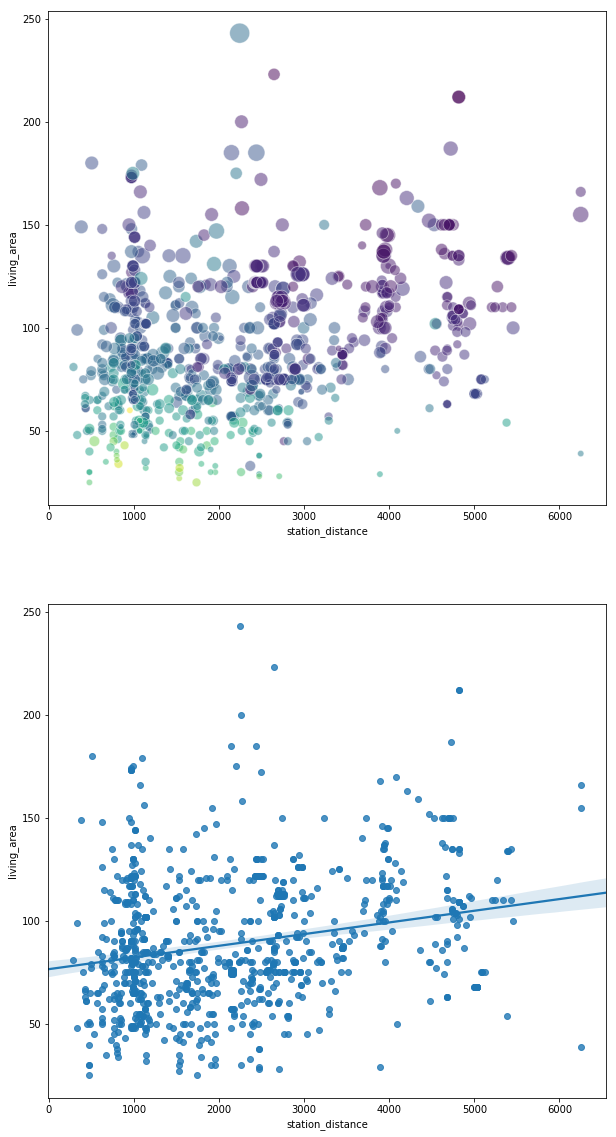

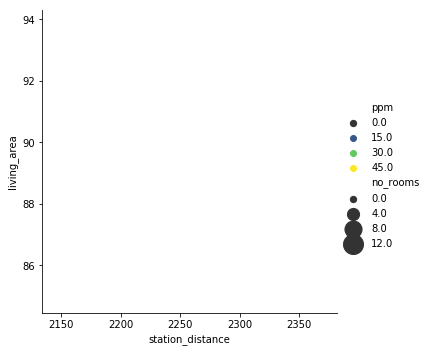

In [31]:
fig, axes = plt.subplots(2, figsize=(10,20))
sns.relplot(x='station_distance',y='living_area',size='no_rooms',hue='ppm',data=df,ax=axes[0],sizes=(40, 400),alpha=0.5,palette='viridis')
sns.regplot(df['station_distance'],df['living_area'], ax=axes[1])

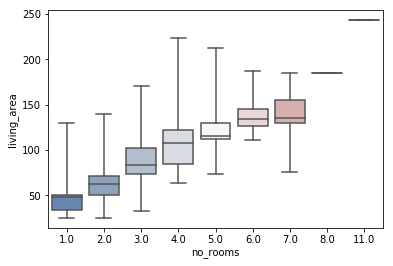

In [32]:
sns.boxplot(x="no_rooms",y='living_area', data=df, whis="range", palette="vlag")

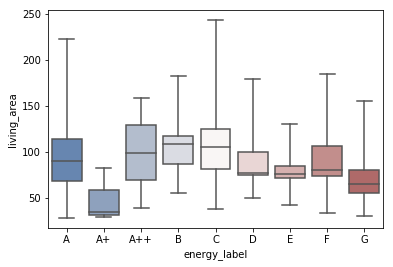

In [33]:
sns.boxplot(x="energy_label",y='living_area', data=df, whis="range", palette="vlag")

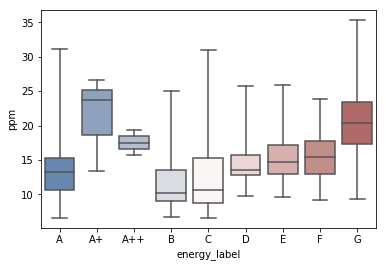

In [69]:
sns.boxplot(x="energy_label",y='ppm', data=df, whis="range", palette="vlag")

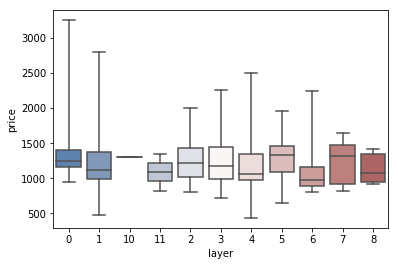

In [35]:
sns.boxplot(x="layer",y='price', data=df, whis="range", palette="vlag")

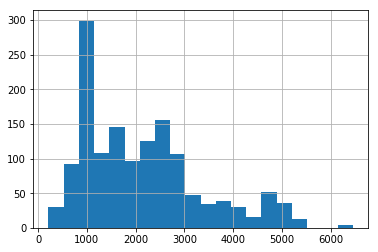

In [36]:
df['station_distance'].hist(bins=20)

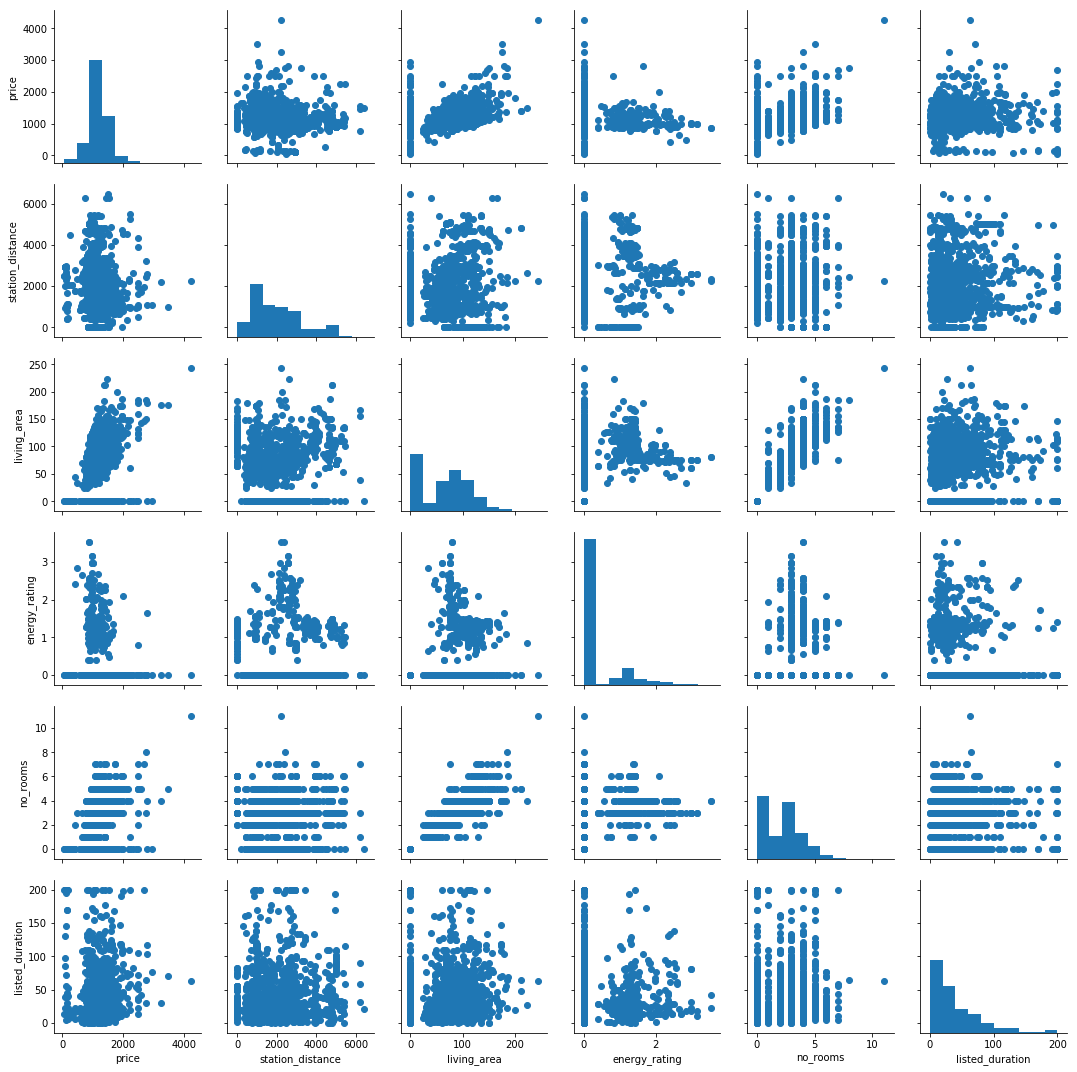

In [62]:
#catcols = ['address','energie_label','parking','warming','water_heating','street','area_code']
ppcols = ['price','station_distance','living_area','energy_rating','no_rooms','listed_duration']
ppdf = df[ppcols]
ppdf.fillna(0.0,inplace=True)
g = sns.PairGrid(ppdf)
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)

In [61]:
df['listed_duration'] = (df['listed_to'] - df['listed_from']).apply(lambda x: np.clip(x.days,0,200))#.hist(bins=100,density=True,cumulative=True,histtype='step')

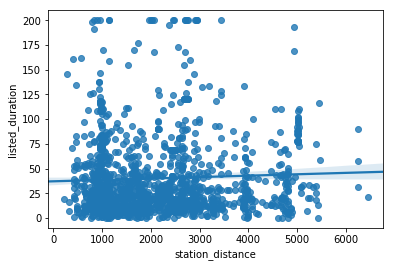

In [63]:
sns.regplot(x='station_distance',y='listed_duration',data=df)

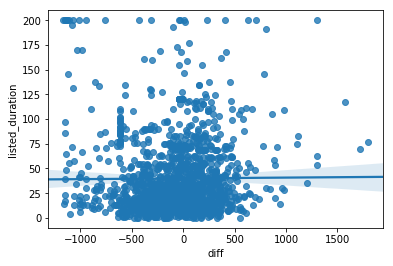

In [67]:
sns.regplot(x=price_pred['diff'], y=df['listed_duration'])